# Using umd.io API to produce insights

By Dominic Graziano

In [263]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

These are the classes I want to pass onto the API to search for. They are all the classes that are required for an InfoSci undergrad student to take in the data science track/specialization.

In [286]:
course_codes = ['MATH115','PSYC100','STAT100','INST126','INST201','INST311','INST314','INST326','INST327','INST335']

I am using the umd.io API and want to access the sections data for the courses that will be passed through

In [287]:
base_url = 'https://api.umd.io/v1/courses/sections?course_id='

The cell below retrieves the data through the umd.io API and then will put it into a list which can be transformed later into a better format for data analysis.

In [288]:
#initialize a list which all of the data will go into
all_course_data = []

for course_code in course_codes:
    # Creates the URL for each of the courses
    course_url = f"{base_url}{course_code}"
    
    # Send the API request for the current course which will be looped through
    response = requests.get(course_url)
    
    # Check if the request was successful (status code 200), and runs the .json()
    if response.status_code == 200:
        # Parse the JSON response into a dictionary
        course_data = response.json()
        
        for item in course_data:
            course = item['course']
            section_id = item['section_id']
            semester = item['semester']
            seats = item['seats']
            meetings = item['meetings']
            open_seats = item['open_seats']
            instructors = item['instructors']
    
            row_data = {
                "Course": course,
                "Section ID": section_id,
                "Semester": semester,
                "Seats": seats,
                'Meetings': meetings,
                "Open Seats": open_seats,
                "Instructors": instructors
            }
            # The data above is appended for each of the courses when th loop is run
            all_course_data.append(row_data)
        
  

Transforms the appended data into a dataframe where we can produce quick analysis' 

In [289]:
df = pd.DataFrame(all_course_data)
df.head()

,Course,Section ID,Semester,Seats,Meetings,Open Seats,Instructors
0,MATH115,MATH115-0111,202308,28,"[{'days': 'MWF', 'room': '0202', 'building': '...",0,[Raluca Rosca]
1,MATH115,MATH115-0121,202308,28,"[{'days': 'MWF', 'room': '0202', 'building': '...",0,[Raluca Rosca]
2,MATH115,MATH115-0131,202308,28,"[{'days': 'MWF', 'room': '0202', 'building': '...",7,[Raluca Rosca]
3,MATH115,MATH115-0141,202308,28,"[{'days': 'MWF', 'room': '0202', 'building': '...",6,[Raluca Rosca]
4,MATH115,MATH115-0151,202308,28,"[{'days': 'MWF', 'room': '0202', 'building': '...",3,[Raluca Rosca]


I noticed that the meetings in the json contained another list so it had to be broken down into a new column for each of the entries

In [266]:
#apply the lambda function to the datafrane which breaks up the meetings column, then we can drop the original meetings
meetings_df = df['Meetings'].apply(lambda x: x[0] if len(x) > 0 else {})
meetings_df = meetings_df.apply(pd.Series)
df = pd.concat([df, meetings_df], axis=1)
df = df.drop(columns='Meetings')

Code to remove the brackets left in the instructors column

In [267]:
df['Instructors'] = df['Instructors'].apply(lambda x: ', '.join(x))

In [268]:
df.head()

,Course,Section ID,Semester,Seats,Open Seats,Instructors,days,room,building,classtype,start_time,end_time
0,MATH115,MATH115-0111,202308,28,0,Raluca Rosca,MWF,0202,ESJ,,9:00am,9:50am
1,MATH115,MATH115-0121,202308,28,0,Raluca Rosca,MWF,0202,ESJ,,9:00am,9:50am
2,MATH115,MATH115-0131,202308,28,7,Raluca Rosca,MWF,0202,ESJ,,9:00am,9:50am
3,MATH115,MATH115-0141,202308,28,6,Raluca Rosca,MWF,0202,ESJ,,9:00am,9:50am
4,MATH115,MATH115-0151,202308,28,3,Raluca Rosca,MWF,0202,ESJ,,9:00am,9:50am


I wanted to add the level at which the course is taken, such that there would be 100, 200, 300, and 400 level courses to classify them, as well as split up and get the department in another column as well

In [290]:
#first line gets the department, second line gets and adds the column of levels
df['department'] = df['Course'].str[:4]
df['level'] = df['Course'].str[-3] + '00'

In [270]:
df.head()

,Course,Section ID,Semester,Seats,Open Seats,Instructors,days,room,building,classtype,start_time,end_time,department,level
0,MATH115,MATH115-0111,202308,28,0,Raluca Rosca,MWF,0202,ESJ,,9:00am,9:50am,MATH,100
1,MATH115,MATH115-0121,202308,28,0,Raluca Rosca,MWF,0202,ESJ,,9:00am,9:50am,MATH,100
2,MATH115,MATH115-0131,202308,28,7,Raluca Rosca,MWF,0202,ESJ,,9:00am,9:50am,MATH,100
3,MATH115,MATH115-0141,202308,28,6,Raluca Rosca,MWF,0202,ESJ,,9:00am,9:50am,MATH,100
4,MATH115,MATH115-0151,202308,28,3,Raluca Rosca,MWF,0202,ESJ,,9:00am,9:50am,MATH,100


There was whitespace in the columns where I wanted there to be a format of the class they needed to be replaced

In [271]:
#gets the classes in the format of online and adds online into the classtype column
online = df['room'] == 'ONLINE'
df.loc[online, 'classtype'] = 'Online'

#gets everything but online classes and assumes in person format into the classtype column
in_person = df['room'] != 'ONLINE'
df.loc[in_person,'classtype'] = 'In Person'

In [272]:
df.head()

,Course,Section ID,Semester,Seats,Open Seats,Instructors,days,room,building,classtype,start_time,end_time,department,level
0,MATH115,MATH115-0111,202308,28,0,Raluca Rosca,MWF,0202,ESJ,In Person,9:00am,9:50am,MATH,100
1,MATH115,MATH115-0121,202308,28,0,Raluca Rosca,MWF,0202,ESJ,In Person,9:00am,9:50am,MATH,100
2,MATH115,MATH115-0131,202308,28,7,Raluca Rosca,MWF,0202,ESJ,In Person,9:00am,9:50am,MATH,100
3,MATH115,MATH115-0141,202308,28,6,Raluca Rosca,MWF,0202,ESJ,In Person,9:00am,9:50am,MATH,100
4,MATH115,MATH115-0151,202308,28,3,Raluca Rosca,MWF,0202,ESJ,In Person,9:00am,9:50am,MATH,100


Graph which shows the format of classes that we got the data on

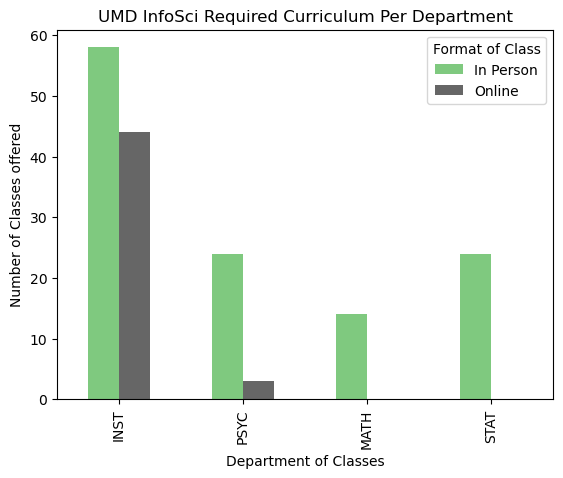

In [273]:
plot_df = df.groupby(['department','classtype']).size().unstack()
plot_df = plot_df.sort_values('Online', ascending = False)
plot_df.plot(kind = 'bar',stacked= False,colormap= 'Accent')

plt.ylabel('Number of Classes offered')
plt.xlabel('Department of Classes')
plt.title('UMD InfoSci Required Curriculum Per Department')
plt.legend(title = 'Format of Class')


This graph breaks down all of the courses we have data on and visualizes the number of seats per all formats offered

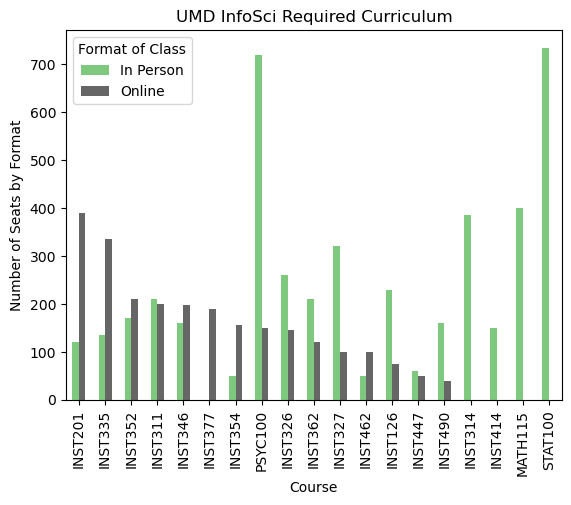

In [274]:
df['Seats'] = df['Seats'].astype(int)
comp_df = df.groupby(['Course','classtype'])['Seats'].sum().unstack()
comp_df = comp_df.sort_values('Online',ascending=False)
comp_df.plot(kind = 'bar', stacked= False,colormap= 'Accent')

plt.ylabel('Number of Seats by Format')
plt.xlabel('Course')
plt.title('UMD InfoSci Required Curriculum')
plt.legend(title = 'Format of Class')


Get the professors that have the most sections out of the classes we have data on

In [275]:
df['Instructors'].value_counts().head(10)

Matthew Griffin              16
Raluca Rosca                 10
Benjamin Jones               10
Abigail Nicolas              10
P Kshetry                     8
Archana Khurana               6
Ryan O'Grady                  6
Scott Jackson                 6
Pamela Duffy, Vedat Diker     6
Jal Irani, Anmol Dash         5
Name: Instructors, dtype: int64

See the distribution of required courses based on the level

In [276]:
count = df['level'].value_counts()
count


300    73
100    70
200    12
400    12
Name: level, dtype: int64

This graph visualizes the distribution of course levels within the required courses

Text(0.5, 1.0, 'UMD InfoSci Required Curriculum')

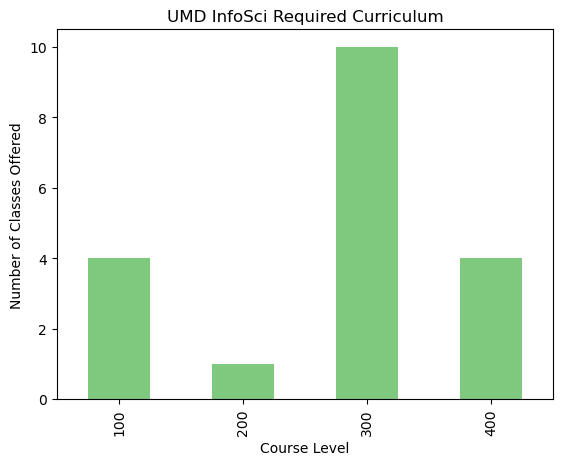

In [277]:
level_course_counts = df.groupby("level")["Course"].nunique()
level_course_counts.plot(kind ='bar',colormap='Accent')

plt.ylabel('Number of Classes Offered')
plt.xlabel('Course Level')
plt.title('UMD InfoSci Required Curriculum')


This graph visualizes the average size of a class within the curriculum while being grouped by the level and department

Text(0.5, 1.0, 'Average Class Size Per Department in InfoSci Curriculum')

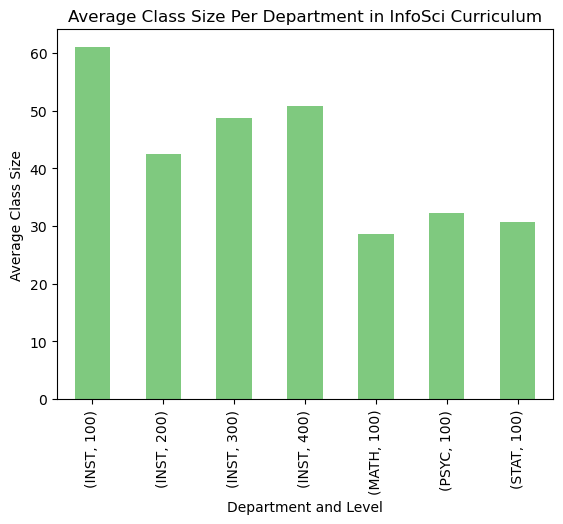

In [285]:
avg_size = df.groupby(['department','level'])['Seats'].mean()
avg_size.plot(kind='bar',colormap='Accent')

plt.ylabel('Average Class Size')
plt.xlabel('Department and Level')
plt.title('Average Class Size Per Department in InfoSci Curriculum')